[Lecture](https://youtu.be/2qOL45sp75c)


[View in Colaboratory](https://colab.research.google.com/github/schwaaweb/aimlds1_08-UnsupervisedLearning/blob/master/W08_CC--DJ--Coding_Challenge_Association_Models.ipynb)

**Coding Challenge**

In this coding challenge, you will apply the concepts of Association Rule Learning

1) Utilize the Apriori Algorithm to uncover frequent itemsets 

2) Discover the strongest association rules that have high lift and high confidence

3) Create a Directed Graph to surface the association rules identified in Step 2 above

**Resources**:

- The Wikipedia articles for [association rule learning](https://en.wikipedia.org/wiki/Association_rule_learning) and the [Apriori algorithm](https://en.wikipedia.org/wiki/Apriori_algorithm) provide a good introduction and overview of the topic.
- The `mlxtend` package provides an [implementation of Apriori](http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/) ([source code](https://github.com/rasbt/mlxtend/blob/master/mlxtend/frequent_patterns/apriori.py)) - it is encouraged to read and understand the documentation and code, so you can be a savvy user of it.
- The `networkx` package has a [tutorial for drawing a directed graph](https://networkx.github.io/documentation/networkx-1.10/tutorial/index.html).


**Dataset: ** The data you will utilize is from the **UCI Machine Learning Repository** and represents transactional data from a UK retailer from 2010 through 2011. The data set represents sales to wholesalers so it is slightly different from data representing customer purchase patterns but is still a useful data set for the purposes of this exercise.

The data set can be downloaded from: http://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx

**Guidance for coding challenge**:

1) Focus on the data for the following 2 countries: 1) **Germany** and 2) **Belgium**. Go through the 3 steps highlighted above for each of the 2 countries. This analysis will enable you to compare/constrast the sales of frequent itemsets in the "Germany" from that in "Belgium"

2) You will need to prepare the data. For example: some of the invoices contact 'C' in front of the invoice number; these ivoices should be removed from the dataset

3) Product descriptions with a value of 'POSTAGE' in it will need to be treated since it could negatively skew/impact the results

4) You will have to transpose the data set so that you get a proper representation of the underlying data set that can be feed into the Apriori Algorithm

*Hint:* Good Reference while exploring your data set - https://medium.com/@msalmon00/helpful-python-code-snippets-for-data-exploration-in-pandas-b7c5aed5ecb9

**Communicate your findings**:

One of the common tasks for Data Scientists in the real world is to communicate their findings. Summarize your analysis and make recomendations on how you could potentially improve/bolster sales for the Online Retailer

In [72]:
#%%bash
#conda install -c conda-forge mlxtend

In [73]:
#!wget -c http://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx
#!mv Online\ Retail.xlsx Online_Retail.xlsx
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import OnehotTransactions, TransactionEncoder



In [74]:
%%time
df = pd.read_excel('Online_Retail.xlsx')

CPU times: user 1min 23s, sys: 811 ms, total: 1min 24s
Wall time: 1min 31s


In [75]:
df.shape

(541909, 8)

In [76]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [78]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [79]:
# Any nulls
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [80]:
# drop the nulls
df.dropna(subset=['Description','CustomerID'], how='any', inplace=True)

In [81]:
#df.drop('POSTAGE', inplace=True, axis=1)

In [82]:
# nulls are gone
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [83]:
# How many contract invoices in the dataframe?
df['InvoiceNo'].str.startswith('c').count()

8905

In [84]:
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [85]:
# remove entries that start with 'c'
df['InvoiceNo'] = df['InvoiceNo'].astype('str')
df = df[~df['InvoiceNo'].str.startswith('C')]
df['InvoiceNo'] = df['InvoiceNo'].astype('int')
print(df.dtypes)

InvoiceNo               int64
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object


In [86]:
df.shape

(397924, 8)

### German Analysis

In [87]:
transactions_per_row = df [df['Country']=='Germany'].pivot_table(index='InvoiceNo',columns='Description', values='Quantity',aggfunc='sum',fill_value=0)

In [88]:
transactions_per_row.head()

Description,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,...,YULETIDE IMAGES GIFT WRAP SET,ZINC HEART T-LIGHT HOLDER,ZINC STAR T-LIGHT HOLDER,ZINC BOX SIGN HOME,ZINC FOLKART SLEIGH BELLS,ZINC HEART LATTICE T-LIGHT HOLDER,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC WILLIE WINKIE CANDLE STICK
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536527,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536840,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536861,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536967,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536983,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [89]:
# Now Drop 'POSTAGE'
transactions_per_row.drop('POSTAGE', inplace=True, axis=1)

In [90]:
%%time
purchase_sets = transactions_per_row.applymap(lambda quantity: 1 if quantity >= 1 else 0)


CPU times: user 739 ms, sys: 5.1 ms, total: 744 ms
Wall time: 772 ms


In [91]:
purchase_sets.head()

Description,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,...,YULETIDE IMAGES GIFT WRAP SET,ZINC HEART T-LIGHT HOLDER,ZINC STAR T-LIGHT HOLDER,ZINC BOX SIGN HOME,ZINC FOLKART SLEIGH BELLS,ZINC HEART LATTICE T-LIGHT HOLDER,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC WILLIE WINKIE CANDLE STICK
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536527,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536840,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536861,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536967,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536983,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [92]:
frequent_itemsets = apriori(purchase_sets, min_support=0.05, use_colnames=True)
association_rules(frequent_itemsets, metric='confidence', min_threshold=0.08)

,antecedants,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(PLASTERS IN TIN WOODLAND ANIMALS),(PLASTERS IN TIN CIRCUS PARADE ),0.137856,0.115974,0.067834,0.492063,4.242887,0.051846,1.740427
1,(PLASTERS IN TIN CIRCUS PARADE ),(PLASTERS IN TIN WOODLAND ANIMALS),0.115974,0.137856,0.067834,0.584906,4.242887,0.051846,2.076984
2,(ROUND SNACK BOXES SET OF 4 FRUITS ),(PLASTERS IN TIN CIRCUS PARADE ),0.157549,0.115974,0.050328,0.319444,2.754455,0.032057,1.298977
3,(PLASTERS IN TIN CIRCUS PARADE ),(ROUND SNACK BOXES SET OF 4 FRUITS ),0.115974,0.157549,0.050328,0.433962,2.754455,0.032057,1.488330
4,(ROUND SNACK BOXES SET OF4 WOODLAND ),(PLASTERS IN TIN CIRCUS PARADE ),0.245077,0.115974,0.056893,0.232143,2.001685,0.028470,1.151290
5,(PLASTERS IN TIN CIRCUS PARADE ),(ROUND SNACK BOXES SET OF4 WOODLAND ),0.115974,0.245077,0.056893,0.490566,2.001685,0.028470,1.481887
6,(PLASTERS IN TIN SPACEBOY),(PLASTERS IN TIN WOODLAND ANIMALS),0.107221,0.137856,0.061269,0.571429,4.145125,0.046488,2.011670
7,(PLASTERS IN TIN WOODLAND ANIMALS),(PLASTERS IN TIN SPACEBOY),0.137856,0.107221,0.061269,0.444444,4.145125,0.046488,1.607002
8,(PLASTERS IN TIN WOODLAND ANIMALS),(ROUND SNACK BOXES SET OF4 WOODLAND ),0.137856,0.245077,0.074398,0.539683,2.202098,0.040613,1.640006
9,(ROUND SNACK BOXES SET OF4 WOODLAND ),(PLASTERS IN TIN WOODLAND ANIMALS),0.245077,0.137856,0.074398,0.303571,2.202098,0.040613,1.237951


In [93]:
association_rules(frequent_itemsets, metric='lift', min_threshold=2)

,antecedants,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(PLASTERS IN TIN WOODLAND ANIMALS),(PLASTERS IN TIN CIRCUS PARADE ),0.137856,0.115974,0.067834,0.492063,4.242887,0.051846,1.740427
1,(PLASTERS IN TIN CIRCUS PARADE ),(PLASTERS IN TIN WOODLAND ANIMALS),0.115974,0.137856,0.067834,0.584906,4.242887,0.051846,2.076984
2,(ROUND SNACK BOXES SET OF 4 FRUITS ),(PLASTERS IN TIN CIRCUS PARADE ),0.157549,0.115974,0.050328,0.319444,2.754455,0.032057,1.298977
3,(PLASTERS IN TIN CIRCUS PARADE ),(ROUND SNACK BOXES SET OF 4 FRUITS ),0.115974,0.157549,0.050328,0.433962,2.754455,0.032057,1.488330
4,(ROUND SNACK BOXES SET OF4 WOODLAND ),(PLASTERS IN TIN CIRCUS PARADE ),0.245077,0.115974,0.056893,0.232143,2.001685,0.028470,1.151290
5,(PLASTERS IN TIN CIRCUS PARADE ),(ROUND SNACK BOXES SET OF4 WOODLAND ),0.115974,0.245077,0.056893,0.490566,2.001685,0.028470,1.481887
6,(PLASTERS IN TIN SPACEBOY),(PLASTERS IN TIN WOODLAND ANIMALS),0.107221,0.137856,0.061269,0.571429,4.145125,0.046488,2.011670
7,(PLASTERS IN TIN WOODLAND ANIMALS),(PLASTERS IN TIN SPACEBOY),0.137856,0.107221,0.061269,0.444444,4.145125,0.046488,1.607002
8,(PLASTERS IN TIN WOODLAND ANIMALS),(ROUND SNACK BOXES SET OF4 WOODLAND ),0.137856,0.245077,0.074398,0.539683,2.202098,0.040613,1.640006
9,(ROUND SNACK BOXES SET OF4 WOODLAND ),(PLASTERS IN TIN WOODLAND ANIMALS),0.245077,0.137856,0.074398,0.303571,2.202098,0.040613,1.237951


In [94]:
def trans_per_row(feature, value_of_feature,min_support,metric,min_threshold):
    transactions_per_row = df [
                                df[ feature ]== value_of_feature
                              ].pivot_table(
                                            index='InvoiceNo',
                                            columns='Description', 
                                            values='Quantity',
                                            aggfunc='sum',
                                            fill_value=0
                                            )
    transactions_per_row.drop('POSTAGE', inplace=True, axis=1)
    purchase_sets = transactions_per_row.applymap(lambda quantity: 1 if quantity >= 1 else 0)
    frequent_itemsets = apriori(purchase_sets, min_support=min_support, use_colnames=True)
    return association_rules(frequent_itemsets, metric=metric, min_threshold=min_threshold)
    

german_tpr = trans_per_row('Country','Germany',0.05,'confidence',0.08)
german_tpr




,antecedants,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(PLASTERS IN TIN WOODLAND ANIMALS),(PLASTERS IN TIN CIRCUS PARADE ),0.137856,0.115974,0.067834,0.492063,4.242887,0.051846,1.740427
1,(PLASTERS IN TIN CIRCUS PARADE ),(PLASTERS IN TIN WOODLAND ANIMALS),0.115974,0.137856,0.067834,0.584906,4.242887,0.051846,2.076984
2,(ROUND SNACK BOXES SET OF 4 FRUITS ),(PLASTERS IN TIN CIRCUS PARADE ),0.157549,0.115974,0.050328,0.319444,2.754455,0.032057,1.298977
3,(PLASTERS IN TIN CIRCUS PARADE ),(ROUND SNACK BOXES SET OF 4 FRUITS ),0.115974,0.157549,0.050328,0.433962,2.754455,0.032057,1.488330
4,(ROUND SNACK BOXES SET OF4 WOODLAND ),(PLASTERS IN TIN CIRCUS PARADE ),0.245077,0.115974,0.056893,0.232143,2.001685,0.028470,1.151290
5,(PLASTERS IN TIN CIRCUS PARADE ),(ROUND SNACK BOXES SET OF4 WOODLAND ),0.115974,0.245077,0.056893,0.490566,2.001685,0.028470,1.481887
6,(PLASTERS IN TIN SPACEBOY),(PLASTERS IN TIN WOODLAND ANIMALS),0.107221,0.137856,0.061269,0.571429,4.145125,0.046488,2.011670
7,(PLASTERS IN TIN WOODLAND ANIMALS),(PLASTERS IN TIN SPACEBOY),0.137856,0.107221,0.061269,0.444444,4.145125,0.046488,1.607002
8,(PLASTERS IN TIN WOODLAND ANIMALS),(ROUND SNACK BOXES SET OF4 WOODLAND ),0.137856,0.245077,0.074398,0.539683,2.202098,0.040613,1.640006
9,(ROUND SNACK BOXES SET OF4 WOODLAND ),(PLASTERS IN TIN WOODLAND ANIMALS),0.245077,0.137856,0.074398,0.303571,2.202098,0.040613,1.237951


In [95]:
german_tpr = trans_per_row('Country','Germany',0.05,'confidence',0.08)
german_tpr

,antecedants,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(PLASTERS IN TIN WOODLAND ANIMALS),(PLASTERS IN TIN CIRCUS PARADE ),0.137856,0.115974,0.067834,0.492063,4.242887,0.051846,1.740427
1,(PLASTERS IN TIN CIRCUS PARADE ),(PLASTERS IN TIN WOODLAND ANIMALS),0.115974,0.137856,0.067834,0.584906,4.242887,0.051846,2.076984
2,(ROUND SNACK BOXES SET OF 4 FRUITS ),(PLASTERS IN TIN CIRCUS PARADE ),0.157549,0.115974,0.050328,0.319444,2.754455,0.032057,1.298977
3,(PLASTERS IN TIN CIRCUS PARADE ),(ROUND SNACK BOXES SET OF 4 FRUITS ),0.115974,0.157549,0.050328,0.433962,2.754455,0.032057,1.488330
4,(ROUND SNACK BOXES SET OF4 WOODLAND ),(PLASTERS IN TIN CIRCUS PARADE ),0.245077,0.115974,0.056893,0.232143,2.001685,0.028470,1.151290
5,(PLASTERS IN TIN CIRCUS PARADE ),(ROUND SNACK BOXES SET OF4 WOODLAND ),0.115974,0.245077,0.056893,0.490566,2.001685,0.028470,1.481887
6,(PLASTERS IN TIN SPACEBOY),(PLASTERS IN TIN WOODLAND ANIMALS),0.107221,0.137856,0.061269,0.571429,4.145125,0.046488,2.011670
7,(PLASTERS IN TIN WOODLAND ANIMALS),(PLASTERS IN TIN SPACEBOY),0.137856,0.107221,0.061269,0.444444,4.145125,0.046488,1.607002
8,(PLASTERS IN TIN WOODLAND ANIMALS),(ROUND SNACK BOXES SET OF4 WOODLAND ),0.137856,0.245077,0.074398,0.539683,2.202098,0.040613,1.640006
9,(ROUND SNACK BOXES SET OF4 WOODLAND ),(PLASTERS IN TIN WOODLAND ANIMALS),0.245077,0.137856,0.074398,0.303571,2.202098,0.040613,1.237951


In [96]:
german_tpr = trans_per_row('Country','Germany',0.05,'lift',4); german_tpr

,antecedants,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(PLASTERS IN TIN WOODLAND ANIMALS),(PLASTERS IN TIN CIRCUS PARADE ),0.137856,0.115974,0.067834,0.492063,4.242887,0.051846,1.740427
1,(PLASTERS IN TIN CIRCUS PARADE ),(PLASTERS IN TIN WOODLAND ANIMALS),0.115974,0.137856,0.067834,0.584906,4.242887,0.051846,2.076984
2,(PLASTERS IN TIN SPACEBOY),(PLASTERS IN TIN WOODLAND ANIMALS),0.107221,0.137856,0.061269,0.571429,4.145125,0.046488,2.011670
3,(PLASTERS IN TIN WOODLAND ANIMALS),(PLASTERS IN TIN SPACEBOY),0.137856,0.107221,0.061269,0.444444,4.145125,0.046488,1.607002
4,(RED RETROSPOT CHARLOTTE BAG),(WOODLAND CHARLOTTE BAG),0.070022,0.126915,0.059081,0.843750,6.648168,0.050194,5.587746
5,(WOODLAND CHARLOTTE BAG),(RED RETROSPOT CHARLOTTE BAG),0.126915,0.070022,0.059081,0.465517,6.648168,0.050194,1.739959


In [97]:
belgium_tpr = trans_per_row('Country','Belgium',0.05,'lift',18); belgium_tpr

,antecedants,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(SET/6 RED SPOTTY PAPER PLATES),(SET/6 RED SPOTTY PAPER CUPS),0.05102,0.05102,0.05102,1.0,19.6,0.048417,inf
1,(SET/6 RED SPOTTY PAPER CUPS),(SET/6 RED SPOTTY PAPER PLATES),0.05102,0.05102,0.05102,1.0,19.6,0.048417,inf
2,"(SET/20 RED RETROSPOT PAPER NAPKINS , SET/6 RE...",(SET/6 RED SPOTTY PAPER CUPS),0.05102,0.05102,0.05102,1.0,19.6,0.048417,inf
3,"(SET/20 RED RETROSPOT PAPER NAPKINS , SET/6 RE...",(SET/6 RED SPOTTY PAPER PLATES),0.05102,0.05102,0.05102,1.0,19.6,0.048417,inf
4,(SET/6 RED SPOTTY PAPER PLATES),"(SET/20 RED RETROSPOT PAPER NAPKINS , SET/6 RE...",0.05102,0.05102,0.05102,1.0,19.6,0.048417,inf
5,(SET/6 RED SPOTTY PAPER CUPS),"(SET/20 RED RETROSPOT PAPER NAPKINS , SET/6 RE...",0.05102,0.05102,0.05102,1.0,19.6,0.048417,inf


In [98]:
belgium_tpr = trans_per_row('Country','Belgium',0.05,'confidence',0.08)

In [99]:
belgium_tpr

,antecedants,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(DOLLY GIRL BABY GIFT SET),( SPACEBOY BABY GIFT SET),0.071429,0.071429,0.061224,0.857143,12.000000,0.056122,6.500000
1,( SPACEBOY BABY GIFT SET),(DOLLY GIRL BABY GIFT SET),0.071429,0.071429,0.061224,0.857143,12.000000,0.056122,6.500000
2,(60 CAKE CASES DOLLY GIRL DESIGN),(PACK OF 60 MUSHROOM CAKE CASES),0.091837,0.081633,0.051020,0.555556,6.805556,0.043524,2.066327
3,(PACK OF 60 MUSHROOM CAKE CASES),(60 CAKE CASES DOLLY GIRL DESIGN),0.081633,0.091837,0.051020,0.625000,6.805556,0.043524,2.421769
4,(60 CAKE CASES DOLLY GIRL DESIGN),(PACK OF 60 SPACEBOY CAKE CASES),0.091837,0.091837,0.061224,0.666667,7.259259,0.052791,2.724490
5,(PACK OF 60 SPACEBOY CAKE CASES),(60 CAKE CASES DOLLY GIRL DESIGN),0.091837,0.091837,0.061224,0.666667,7.259259,0.052791,2.724490
6,(60 CAKE CASES DOLLY GIRL DESIGN),(PACK OF 72 RETROSPOT CAKE CASES),0.091837,0.122449,0.051020,0.555556,4.537037,0.039775,1.974490
7,(PACK OF 72 RETROSPOT CAKE CASES),(60 CAKE CASES DOLLY GIRL DESIGN),0.122449,0.091837,0.051020,0.416667,4.537037,0.039775,1.556851
8,(AIRLINE BAG VINTAGE JET SET RED),(ROUND SNACK BOXES SET OF4 WOODLAND ),0.051020,0.387755,0.051020,1.000000,2.578947,0.031237,inf
9,(ROUND SNACK BOXES SET OF4 WOODLAND ),(AIRLINE BAG VINTAGE JET SET RED),0.387755,0.051020,0.051020,0.131579,2.578947,0.031237,1.092764


In [100]:
import networkx as netx
import matplotlib.pyplot as plt

def draw_association_graph(rules, rules_to_show):
  """Function to draw graph visualization association rules."""
  DiGraph = netx.DiGraph()
  
  colors = np.random.rand(rules_to_show)
  rule_nodes = set()
  
  for i in range(rules_to_show):
    rule_node = 'R' + str(i)
    DiGraph.add_nodes_from([rule_node])
    rule_nodes.add(rule_node)
    lift = rules.iloc[i]['lift']
    
    # For antecedant, the arrow originates from antecedant to the Rule node
    for antecedant in rules.iloc[i]['antecedants']:
      DiGraph.add_nodes_from([antecedant])
      DiGraph.add_edge(antecedant, rule_node, color=colors[i], weight=lift)
    
    # For consequent, the arrow originates fromt he Rule node to the consequent
    for consequent in rules.iloc[i]['consequents']:
      DiGraph.add_edge(rule_node, consequent, color=colors[i], weight=lift)
  
  # Set the color of rule nodes to orange, non-rule nodes to green
  node_colors = ['orange' if node in rule_nodes else 'green'
                 for node in DiGraph]
  
  # Print/draw results!
  edges = DiGraph.edges()
  nodes = DiGraph.nodes()
  print('Nodes: ' + str(nodes))
  print('Edges: ' + str(edges))
  
  edge_colors = [DiGraph[src][dest]['color'] for src, dest in edges]
  edge_weights =  [DiGraph[src][dest]['weight'] for src, dest in edges]
  
  positions = netx.spring_layout(DiGraph, k=15, scale=1)
  print("Node positions: " + str(positions))
  netx.draw_networkx(DiGraph, positions, edges=edges, node_color=node_colors,
                    edge_color=edge_colors, width=edge_weights, font_size=16,
                    with_labels=False)
  
  # Add labels under nodes
  for position in positions:
    positions[position][1] -= 0.15
  netx.draw_networkx_labels(DiGraph, positions)
  plt.show()

In [101]:
def analyze_country(country, min_support=0.10, lift_threshold=4):
  """Run associaton rule analysis for a given country."""
  transactions_per_row = df[df['Country'] == country].pivot_table(
      index='InvoiceNo', columns='Description', values='Quantity',
      aggfunc='sum', fill_value=0)
  # Let's get rid of postage, it's not really a product
  transactions_per_row.drop('POSTAGE', inplace=True, axis=1)
  # Last bit of cleaning - we only care if a transaction includes an item or not
  purchase_sets = transactions_per_row.applymap(
      lambda quantity: 1 if quantity >= 1 else 0)
  # Time for Apriori!
  # Calculate support (indication of how frequently itemset appears in data)
  # and confidence (indication of how often a rule is true)
  frequent_itemsets = apriori(purchase_sets, min_support=min_support,
                              use_colnames=True)
  associationrules = association_rules(frequent_itemsets, metric='lift',
                                       min_threshold=lift_threshold)
  draw_association_graph(associationrules, associationrules.shape[0])



Nodes: ['R0', 'ALARM CLOCK BAKELIKE RED ', 'ALARM CLOCK BAKELIKE GREEN', 'R1', 'R2', 'ALARM CLOCK BAKELIKE PINK', 'R3', 'R4', 'LUNCH BAG WOODLAND', 'LUNCH BAG RED RETROSPOT', 'R5', 'R6', 'RED RETROSPOT CHARLOTTE BAG', 'WOODLAND CHARLOTTE BAG', 'R7']
Edges: [('R0', 'ALARM CLOCK BAKELIKE GREEN'), ('ALARM CLOCK BAKELIKE RED ', 'R0'), ('ALARM CLOCK BAKELIKE RED ', 'R2'), ('ALARM CLOCK BAKELIKE GREEN', 'R1'), ('R1', 'ALARM CLOCK BAKELIKE RED '), ('R2', 'ALARM CLOCK BAKELIKE PINK'), ('ALARM CLOCK BAKELIKE PINK', 'R3'), ('R3', 'ALARM CLOCK BAKELIKE RED '), ('R4', 'LUNCH BAG RED RETROSPOT'), ('LUNCH BAG WOODLAND', 'R4'), ('LUNCH BAG RED RETROSPOT', 'R5'), ('R5', 'LUNCH BAG WOODLAND'), ('R6', 'WOODLAND CHARLOTTE BAG'), ('RED RETROSPOT CHARLOTTE BAG', 'R6'), ('WOODLAND CHARLOTTE BAG', 'R7'), ('R7', 'RED RETROSPOT CHARLOTTE BAG')]
Node positions: {'R0': array([-0.95958141,  0.10521557]), 'ALARM CLOCK BAKELIKE RED ': array([0.24729243, 0.9121764 ]), 'ALARM CLOCK BAKELIKE GREEN': array([-0.80828619

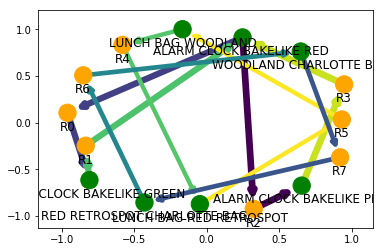

In [102]:
analyze_country('Belgium', min_support=0.08)

Nodes: ['R0', 'PLASTERS IN TIN WOODLAND ANIMALS', 'PLASTERS IN TIN CIRCUS PARADE ', 'R1', 'R2', 'PLASTERS IN TIN SPACEBOY', 'R3', 'R4', 'RED RETROSPOT CHARLOTTE BAG', 'WOODLAND CHARLOTTE BAG', 'R5']
Edges: [('R0', 'PLASTERS IN TIN CIRCUS PARADE '), ('PLASTERS IN TIN WOODLAND ANIMALS', 'R0'), ('PLASTERS IN TIN WOODLAND ANIMALS', 'R3'), ('PLASTERS IN TIN CIRCUS PARADE ', 'R1'), ('R1', 'PLASTERS IN TIN WOODLAND ANIMALS'), ('R2', 'PLASTERS IN TIN WOODLAND ANIMALS'), ('PLASTERS IN TIN SPACEBOY', 'R2'), ('R3', 'PLASTERS IN TIN SPACEBOY'), ('R4', 'WOODLAND CHARLOTTE BAG'), ('RED RETROSPOT CHARLOTTE BAG', 'R4'), ('WOODLAND CHARLOTTE BAG', 'R5'), ('R5', 'RED RETROSPOT CHARLOTTE BAG')]
Node positions: {'R0': array([-0.83801264, -0.59068443]), 'PLASTERS IN TIN WOODLAND ANIMALS': array([ 0.85224424, -0.30153357]), 'PLASTERS IN TIN CIRCUS PARADE ': array([0.6216882 , 0.65237998]), 'R1': array([0.23613832, 1.        ]), 'R2': array([-0.98353331,  0.00766244]), 'PLASTERS IN TIN SPACEBOY': array([-0.3

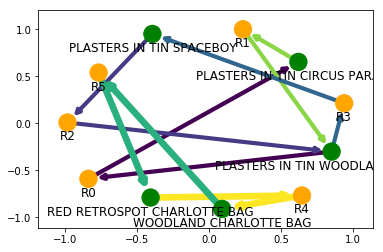

In [103]:
analyze_country('Germany', min_support=0.05)

In [104]:
#!git status && git add . && git status

In [105]:
#!git commit -am "Testing the if the notebook runs cleanly from top to bottom, now with run all cells"

In [106]:
#!git status && git push && git status && date